In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

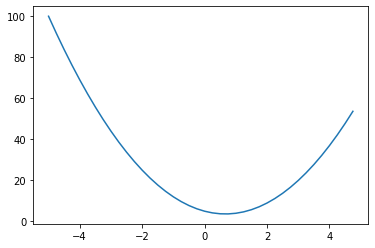

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [6]:
#more complex (talking about derivatives)
a = 2.0
b = -3.0
c = 10.0
d = a*b  + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a*b  + c
a += h
d2 = a*b  + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''): #children->empty tuple
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #by default it does nothing
        self._prev = set(_children) #in the class it will be a set
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        # in add the gradient distrubution flows equally to its childs
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward #function that propagates the gradient

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        #in mul we use the chain rule of derivatives
        def _backward():
            self.grad += other.data * out.grad  #chain rule!
            other.grad += self.data * out.grad  #chain rule!
        out._backward = _backward

        return out

    #using tanh function to "squish" the output
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh') #just one child, self, a tuple
    
        def _backward():
            #derivative of tanh chain ruled to out.grad into self.grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):

        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [10]:
def lol():
    
    #examples for manual backpropagation
    
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

0.002000000000279556


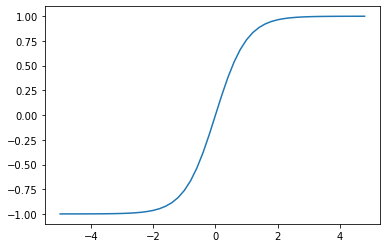

In [11]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid;

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

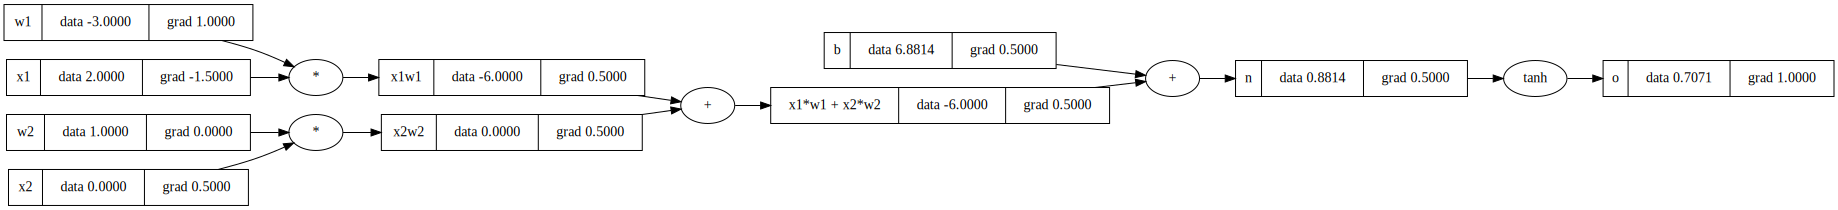

In [13]:
draw_dot(o)

In [14]:
# o is the outcome of tanh
o.grad = 1.0

In [15]:
o._backward()

In [16]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)
topo


[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [17]:
# backpropagation is essentially a reverse topological sort
# we define the backward func as a topological sort, but reversed
def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.addI(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    build_topo(self)

    # reversing the topological sort algorithm, we have a linearized graph
    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

In [18]:
n._backward() # manual backprop

In [19]:
b._backward() # its a leaf node so in points to None

In [20]:
x1w1x2w2._backward() # manual backprop

In [21]:
x1w1._backward() # manual backprop 
x2w2._backward()

In [22]:
x1.grad = w1.data * x1w1.grad # manual backprop
w1.grad = x1.data * x1w1.grad

In [23]:
x2.grad = w2.data * x2w2.grad # manual backprop
w2.grad = w2.data * x2w2.grad

In [24]:
x1w1.grad = 0.5 # manual backprop
x2w2.grad = 0.5

In [26]:
x1w1x2w2.grad = 0.5 # manual backprop
b.grad = 0.5